# Project 2 ECE 236A

**Samuel Gessow** (sgessow@gmail.com), **Steven Zhiying Li** (zhiyingli@g.ucla.edu), **Sunay Bhat** (sunaybhat1@ucla.edu), **Terri Tsai** (terri0716@gmail.com), **Dominic Yang** (domyang@g.ucla.edu)

In [159]:
import pandas as pd
import numpy as np
import cvxpy as cp

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib notebook

In [2]:
import MyDecoder as decoder

# for automatically reloading the imported modules
%load_ext autoreload
%autoreload 2

## SSS

In [3]:
X = np.array([[1,1,1,1,0,0,0,0],
              [0,0,0,0,1,1,1,1],
              [1,1,0,0,0,0,0,0],
              [0,0,1,0,0,0,0,0],
              [0,0,1,0,1,1,0,1],
              [0,0,0,0,1,0,0,0]])

y = np.array([1,1,0,1,1,1])

ppl_pred  = decoder.lp(X,y)
ppl_pred

array([0., 0., 1., 0., 1., 0., 0., 0.])

In [122]:
Xs = {}
ppls = {}
ys = {}
preds = {}
p = 0.1
n = 1000
T_list = range(100, 800, 100)
num_trial = 10;

for i in range(num_trial):
    for T in T_list:
        print(i, T)
        X, ppl, y = decoder.generator(n, p, T)
        Xs[i,T], ppls[i,T], ys[i,T] = X, ppl, y
        ppl_pred  = decoder.solve_lp(X,y)
        ppl_pred[ppl_pred < 1e-8] = 0
        ppl_pred[ppl_pred > 1 - 1e-8] = 1
        preds[i,T] = ppl_pred

0 100
0 200
0 300
0 400
0 500
0 600
0 700
1 100
1 200
1 300
1 400
1 500
1 600
1 700
2 100
2 200
2 300
2 400
2 500
2 600
2 700
3 100
3 200
3 300
3 400
3 500
3 600
3 700
4 100
4 200
4 300
4 400
4 500
4 600
4 700
5 100
5 200
5 300
5 400
5 500
5 600
5 700
6 100
6 200
6 300
6 400
6 500
6 600
6 700
7 100
7 200
7 300
7 400
7 500
7 600
7 700
8 100
8 200
8 300
8 400
8 500
8 600
8 700
9 100
9 200
9 300
9 400
9 500
9 600
9 700


In [26]:
preds

{(0, 100): array([0.        , 0.11111111, 0.        , 0.08333333, 0.08333333,
        0.        , 0.09090909, 0.06666667, 0.        , 0.125     ,
        0.08333333, 0.        , 0.06666667, 0.        , 0.        ,
        0.06666667, 0.09090909, 0.08333333, 0.        , 0.        ,
        0.        , 0.        , 0.07692308, 0.125     , 0.        ,
        0.16666667, 0.1       , 0.08333333, 0.06666667, 0.11111111,
        0.        , 0.2       , 0.1       , 0.        , 0.        ,
        0.125     , 0.06666667, 0.08333333, 0.05555556, 0.125     ,
        0.11111111, 0.125     , 0.07142857, 0.1       , 0.06666667,
        0.11111111, 0.07692308, 0.        , 0.07692308, 0.08333333,
        0.08333333, 0.11111111, 0.        , 0.08333333, 0.        ,
        0.        , 0.125     , 0.1       , 0.        , 0.16666667,
        0.125     , 0.        , 0.        , 0.1       , 0.        ,
        0.1       , 0.        , 0.1       , 0.1       , 0.07692308,
        0.125     , 0.07692308, 0.0769

In [5]:
def threshold(z, tau):
    pred = z.copy()
    pred[z >= tau] = 1
    pred[z < tau] = 0
    return pred

In [27]:
def num_false_negatives(ppl, ppl_pred):
    return sum((ppl - ppl_pred) == 1)

def num_false_positives(ppl, ppl_pred):
    return sum((ppl - ppl_pred) == -1)

def hamming_distance(ppl, ppl_pred):
    return sum(abs(ppl - ppl_pred))

In [8]:
def rounding_scheme(X, y, rel):
    satisfied_rows = y == 0
    for i in range(len(y)):
        if y[i] == 1:
            tested_ppl = X[i].nonzero()
            if np.any(rel[tested_ppl] == 1):
                satisfied_rows[i] = True
    
    unsatisfied_rows = (~satisfied_rows)
    unset_people = ((rel != 0) & (rel != 1))
    mask = (X[unsatisfied_rows].sum(axis=0) > 0) & unset_people
    while np.any(unsatisfied_rows):
        mask = (X[unsatisfied_rows].sum(axis=0) > 0) & unset_people
        person = mask.nonzero()[0][rel[mask].argmax()]
        rel[person] = 1
        unset_people[person] = False
        satisfied_rows[X[:,person] == 1] = True
        unsatisfied_rows = ~satisfied_rows
    rel[rel < 1] = 0
    return rel

In [29]:
FNs = {}
FPs = {}
HDs = {}

thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

for t in thresholds:
    for i in range(10):
        for T in T_list:
            pred = threshold(preds[i,T], t)
            ppl = ppls[i,T]
            FNs[i,T,t] = num_false_negatives(ppl, pred)
            FPs[i,T,t] = num_false_positives(ppl, pred)
            HDs[i,T,t] = hamming_distance(ppl, pred)
            

In [30]:
avg_FNs = {}
avg_FPs = {}
avg_HDs = {}

for t in thresholds:
    avg_FNs[t] = [np.mean([FNs[i,T,t] for i in range(num_trial)]) for T in T_list]
    avg_FPs[t] = [np.mean([FPs[i,T,t] for i in range(num_trial)]) for T in T_list]
    avg_HDs[t] = [np.mean([HDs[i,T,t] for i in range(num_trial)]) for T in T_list]

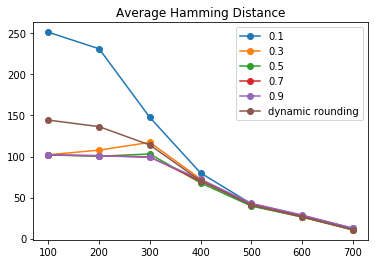

In [37]:
plt.figure()
for t in thresholds:
    plt.plot(T_list, avg_HDs[t], '-o', label=t)
    plt.title('Average Hamming Distance')
plt.plot(T_list, round_avg_HDs, '-o', label='dynamic rounding')
plt.legend()

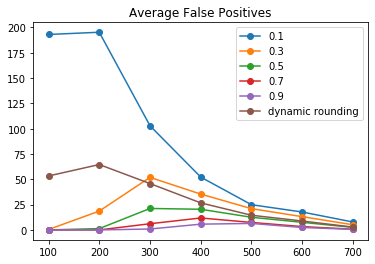

In [38]:
plt.figure()
for t in thresholds:
    plt.plot(T_list, avg_FPs[t], '-o', label=t)
    plt.title('Average False Positives')
plt.plot(T_list, round_avg_FPs, '-o', label='dynamic rounding')
plt.legend()

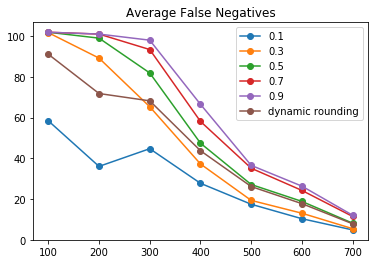

In [39]:
plt.figure()
for t in thresholds:
    plt.plot(T_list, avg_FNs[t], '-o', label=t)
    plt.title('Average False Negatives')
    plt.legend()
plt.plot(T_list, round_avg_FNs, '-o', label='dynamic rounding')
plt.legend()

In [36]:
round_FNs = {}
round_FPs = {}
round_HDs = {}

for i in range(10):
    for T in T_list:
        pred = rounding_scheme(Xs[i,T], ys[i,T], preds[i,T].copy())
        ppl = ppls[i,T]
        round_FNs[i,T] = num_false_negatives(ppl, pred)
        round_FPs[i,T] = num_false_positives(ppl, pred)
        round_HDs[i,T] = hamming_distance(ppl, pred)

round_avg_FNs = [np.mean([round_FNs[i,T] for i in range(num_trial)]) for T in T_list]
round_avg_FPs = [np.mean([round_FPs[i,T] for i in range(num_trial)]) for T in T_list]
round_avg_HDs = [np.mean([round_HDs[i,T] for i in range(num_trial)]) for T in T_list]

In [9]:
def run_lp_trials(p, n, T_list, num_trial):
    Hamming_err_lists = []
    FN_lists = []
    FP_lists = []

    for i in range(num_trial):
        Hamming_err_list = []
        FN_list = []
        FP_list = []

        for T in T_list:
            X, ppl, y = decoder.generator(n, p, T)
            ppl_pred  = decoder.lp(X,y)

            Hamming_err = sum(ppl_pred != ppl)/nt
            Hamming_err_list.append(Hamming_err)

            positive_mask = (ppl == 1)
            FN = sum(ppl_pred[positive_mask] == 0) / sum(positive_mask)
            FN_list.append(FN)

            negative_mask = (ppl == 0)
            FP = sum(ppl_pred[negative_mask] == 1) / sum(positive_mask)
            FP_list.append(FP)

        Hamming_err_lists.append(Hamming_err_list)
        FN_lists.append(FN_list)
        FP_lists.append(FP_list)
    
    return Hamming_err_lists, FN_lists, FP_lists

In [10]:
def make_plot(n,p, Hamming_err_lists, FN_lists, FP_lists, T_list, num_trial):
    AVG_Hamming_err_list = np.average(Hamming_err_lists,axis=0)
    AVG_FN_list = np.average(FN_lists,axis=0)
    AVG_FP_list = np.average(FP_lists,axis=0)

    plt.subplot(1,3,1)
    for i in range(num_trial):
        #plt.plot(T_list, Hamming_err_lists[i], label = "Hamming Err", color='blue', alpha=0.3)
        plt.plot(T_list, Hamming_err_lists[i],'o', color='blue', alpha=0.3);   
    plt.plot(T_list, AVG_Hamming_err_list, label = "Averaged Hamming Err", linewidth = 3, color='blue')
    plt.plot(T_list, AVG_Hamming_err_list,'o', color='blue');
    plt.xlabel("T (number of tests)")
    plt.ylabel("Hamming Error Rate")
    plt.title("T (number of tests) vs Hamming, p = "+str(p)+", n = "+str(n))
    plt.grid(True)
    plt.legend(loc='upper right')

    plt.subplot(1,3,2)
    for i in range(num_trial):
        plt.plot(T_list, FN_lists[i],'o', color='blue', alpha=0.3);   
    plt.plot(T_list, AVG_FN_list, label = "Averaged False Negative", linewidth = 3, color='blue')
    plt.plot(T_list, AVG_FN_list,'o', color='blue');
    plt.xlabel("T (number of tests)")
    plt.ylabel("False Negative")
    plt.title("T (number of tests) vs False Negative, p = "+str(p)+", n = "+str(n))
    plt.grid(True)
    plt.legend(loc='upper right')

    plt.subplot(1,3,3)
    for i in range(num_trial):
        plt.plot(T_list, FP_lists[i],'o', color='blue', alpha=0.3);   
    plt.plot(T_list, AVG_FP_list, label = "Averaged False Positive", linewidth = 3, color='blue')
    plt.plot(T_list, AVG_FP_list,'o', color='blue');
    plt.xlabel("T (number of tests)")
    plt.title("T (number of tests) vs False Positive p = "+str(p)+", n = "+str(n))
    plt.ylabel("False Positive")
    plt.grid(True)
    plt.legend(loc='upper right')

    fig.set_size_inches(18, 4)

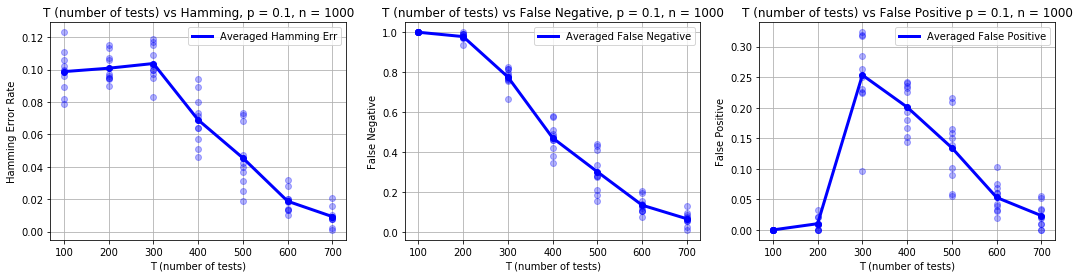

In [11]:
p = 0.1
n = 1000
T_list = range(100, 800, 100)
num_trial = 10;

Hamming_err_lists, FN_lists, FP_lists = run_lp_trials(p, n, T_list, num_trial)

fig = plt.figure(1)
make_plot(n,p, Hamming_err_lists, FN_lists, FP_lists, T_list, num_trial)
plt.show()

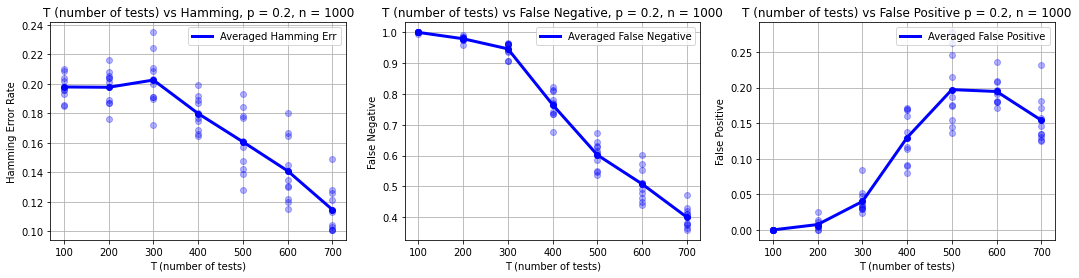

In [7]:
p = 0.2
n = 1000
T_list = range(100, 800, 100)
num_trial = 10;

Hamming_err_lists, FN_lists, FP_lists = run_lp_trials(p, n, T_list, num_trial)

fig = plt.figure(2)
make_plot(n,p, Hamming_err_lists, FN_lists, FP_lists, T_list, num_trial)
plt.show()

In [40]:
Xs = {}
ppls = {}
ys = {}
preds = {}
As = {}
q = 0.1
p = 0.8
m = 200
n = 1000
T = 100
num_trial = 10

X, ppl, y, A = decoder.generator_nonoverlapping(n, q, p, m, T)

In [67]:
rel = decoder.solve_lp(X, y)
rel[rel < 1e-8] = 0
rel[rel > 1 - 1e-8] = 0

In [85]:
X.shape

(100, 1000)

In [86]:
X[0,A[0].nonzero()[0]]

array([0.])

In [75]:
def construct_group_test_matrix(X, A, rel):
    """
    Pass in test matrix X, group assignment matrix A, 
    and solution to linear relaxation rel.
    """
    m = A.shape[0]
    T = X.shape[0]
    group_X = np.zeros((T,m))
    for j in range(m):
        group_members = A[j].nonzero()[0]
        tests = X[:,group_members] == 1
        neg_group_ppl = rel[group_members] == 0
        group_X[:,j] = np.any(tests & ~neg_group_ppl, axis=1)
        
    return group_X

In [78]:
construct_group_test_matrix(X, A, rel)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [82]:
def round_with_groups(X, y, A):    
    ppl_pred  = decoder.solve_lp(X,y)
    ppl_pred[ppl_pred < 1e-8] = 0
    ppl_pred[ppl_pred > 1 - 1e-8] = 1
    
    group_X = construct_group_test_matrix(X, A, ppl_pred)
    group_pred = decoder.solve_lp(group_X[y != 0], y[y != 0])
    group_pred[group_pred < 1e-8] = 0
    group_pred[group_pred > 1 - 1e-8] = 1
    inf_groups = rounding_scheme(group_X[y != 0], y[y != 0], group_pred)
    group_assignments = np.argwhere(A.T != 0)[:,1]

    ppl_pred[inf_groups[group_assignments] == 0] = 0
    
    inf_people = rounding_scheme(X, y, ppl_pred)
    return inf_people

In [83]:
inf_people = {}

for i in range(num_trial):
    for T in T_list:
        X, ppl, y, A = decoder.generator_nonoverlapping(n, q, p, m, T)
        Xs[i,T], ppls[i,T], ys[i,T], As[i,T] = X, ppl, y, A
        ppl_pred  = decoder.solve_lp(X,y)
        ppl_pred[ppl_pred < 1e-8] = 0
        ppl_pred[ppl_pred > 1 - 1e-8] = 1
        preds[i,T] = ppl_pred
        inf_people[i,T] = round_with_groups(X, y, A)

In [89]:
FNs = {}
FPs = {}
HDs = {}

thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

for t in thresholds:
    for i in range(10):
        for T in T_list:
            pred = threshold(preds[i,T], t)
            ppl = ppls[i,T]
            FNs[i,T,t] = num_false_negatives(ppl, pred)
            FPs[i,T,t] = num_false_positives(ppl, pred)
            HDs[i,T,t] = hamming_distance(ppl, pred)

avg_FNs = {}
avg_FPs = {}
avg_HDs = {}

for t in thresholds:
    avg_FNs[t] = [np.mean([FNs[i,T,t] for i in range(num_trial)]) for T in T_list]
    avg_FPs[t] = [np.mean([FPs[i,T,t] for i in range(num_trial)]) for T in T_list]
    avg_HDs[t] = [np.mean([HDs[i,T,t] for i in range(num_trial)]) for T in T_list]

In [87]:
round_FNs = {}
round_FPs = {}
round_HDs = {}

for i in range(10):
    for T in T_list:
        pred = rounding_scheme(Xs[i,T], ys[i,T], preds[i,T].copy())
        ppl = ppls[i,T]
        round_FNs[i,T] = num_false_negatives(ppl, pred)
        round_FPs[i,T] = num_false_positives(ppl, pred)
        round_HDs[i,T] = hamming_distance(ppl, pred)

round_avg_FNs = [np.mean([round_FNs[i,T] for i in range(num_trial)]) for T in T_list]
round_avg_FPs = [np.mean([round_FPs[i,T] for i in range(num_trial)]) for T in T_list]
round_avg_HDs = [np.mean([round_HDs[i,T] for i in range(num_trial)]) for T in T_list]

In [84]:
group_FNs = {}
group_FPs = {}
group_HDs = {}

for i in range(10):
    for T in T_list:
        pred = inf_people[i,T]
        ppl = ppls[i,T]
        group_FNs[i,T] = num_false_negatives(ppl, pred)
        group_FPs[i,T] = num_false_positives(ppl, pred)
        group_HDs[i,T] = hamming_distance(ppl, pred)

group_avg_FNs = [np.mean([group_FNs[i,T] for i in range(num_trial)]) for T in T_list]
group_avg_FPs = [np.mean([group_FPs[i,T] for i in range(num_trial)]) for T in T_list]
group_avg_HDs = [np.mean([group_HDs[i,T] for i in range(num_trial)]) for T in T_list]

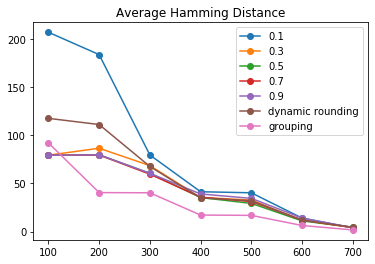

In [90]:
plt.figure()
for t in thresholds:
    plt.plot(T_list, avg_HDs[t], '-o', label=t)
    plt.title('Average Hamming Distance')
plt.plot(T_list, round_avg_HDs, '-o', label='dynamic rounding')
plt.plot(T_list, group_avg_HDs, '-o', label='grouping')
plt.legend()

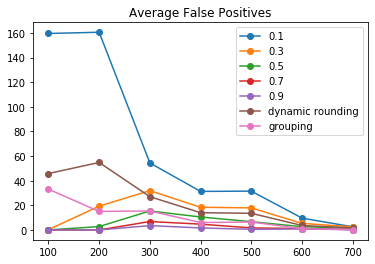

In [92]:
plt.figure()
for t in thresholds:
    plt.plot(T_list, avg_FPs[t], '-o', label=t)
    plt.title('Average False Positives')
plt.plot(T_list, round_avg_FPs, '-o', label='dynamic rounding')
plt.plot(T_list, group_avg_FPs, '-o', label='grouping')
plt.legend()

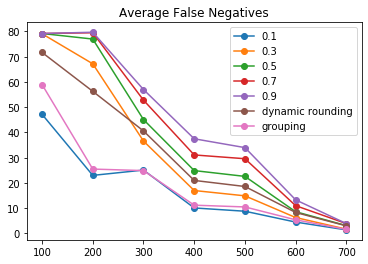

In [94]:
plt.figure()
for t in thresholds:
    plt.plot(T_list, avg_FNs[t], '-o', label=t)
    plt.title('Average False Negatives')
plt.plot(T_list, round_avg_FNs, '-o', label='dynamic rounding')
plt.plot(T_list, group_avg_FNs, '-o', label='grouping')
plt.legend()

In [85]:
def plot_error_rates(ppls, predictions):
    group_FNs = {}
    group_FPs = {}
    group_HDs = {}

    for i in range(10):
        for T in T_list:
            pred = predictions[i,T]
            ppl = ppls[i,T]
            group_FNs[i,T] = num_false_negatives(ppl, pred)
            group_FPs[i,T] = num_false_positives(ppl, pred)
            group_HDs[i,T] = hamming_distance(ppl, pred)

    group_avg_FNs = [np.mean([group_FNs[i,T] for i in range(num_trial)]) for T in T_list]
    group_avg_FPs = [np.mean([group_FPs[i,T] for i in range(num_trial)]) for T in T_list]
    group_avg_HDs = [np.mean([group_HDs[i,T] for i in range(num_trial)]) for T in T_list]
    
    plt.subplot(131)
    plt.plot(group_avg_HDs)
    plt.title('Average Hamming Distance')
    plt.ylim(0, 200)
    
    plt.subplot(132)
    plt.plot(group_avg_FNs)
    plt.title('Average # False Negatives')
    plt.ylim(0, 200)
    
    plt.subplot(133)
    plt.plot(group_avg_FPs)
    plt.title('Average # False Positive')
    plt.ylim(0, 200)
    

In [319]:
def run_test(n, q, p, m):
    Xs = {}
    ppls = {}
    ys = {}
    preds = {}
    As = {}
    num_trial = 10
    T_list = [100, 200, 300, 400, 500, 600, 700]
    
    for i in range(num_trial):
        for T in T_list:
            X, ppl, y, A = decoder.generator_nonoverlapping(n, q, p, m, T)
            Xs[i,T], ppls[i,T], ys[i,T], As[i,T] = X, ppl, y, A
            preds[i,T] = round_with_groups(X, y, A)
    return Xs, ppls, ys, As, preds

In [303]:
T = 700
X, ppl, y, A = decoder.generator_nonoverlapping(n, q, p, m, T)
Xs[i,T], ppls[i,T], ys[i,T], As[i,T] = X, ppl, y, A
inf_people[i,T] = round_with_groups(X, y, A)

In [320]:
X_1, ppl_1, y_1, A_1, preds_1 = run_test(1000, 0.1, 0.8, 200)
X_2, ppl_2, y_2, A_2, preds_2 = run_test(1000, 0.2, 0.6, 200)
X_3, ppl_3, y_3, A_3, preds_3 = run_test(1000, 0.1, 0.8, 20)
X_4, ppl_4, y_4, A_4, preds_4 = run_test(1000, 0.2, 0.6, 20)

In [147]:
zs = {}
y_noisys = {}
e_negs = {}


for i in range(num_trial):
    for T in T_list:
        X, y = Xs[i,T], ys[i,T]
        y_noisy = decoder.add_noise_zchannel(y, 0.1)
        y_noisys[i,T] = y_noisy
        for L in np.linspace(-1, 0, 11):
            L = round(L, 1)
            print(i, T, L)
            zs[i,T,L], e_negs[i,T,L] = decoder.solve_lp_z(X, y_noisy, L)

0 100 -1.0
0 100 -0.9
0 100 -0.8
0 100 -0.7
0 100 -0.6
0 100 -0.5
0 100 -0.4
0 100 -0.3
0 100 -0.2
0 100 -0.1
0 100 0.0
0 200 -1.0
0 200 -0.9
0 200 -0.8
0 200 -0.7
0 200 -0.6
0 200 -0.5
0 200 -0.4
0 200 -0.3
0 200 -0.2
0 200 -0.1
0 200 0.0
0 300 -1.0
0 300 -0.9
0 300 -0.8
0 300 -0.7
0 300 -0.6
0 300 -0.5
0 300 -0.4
0 300 -0.3
0 300 -0.2
0 300 -0.1
0 300 0.0
0 400 -1.0
0 400 -0.9
0 400 -0.8
0 400 -0.7
0 400 -0.6
0 400 -0.5
0 400 -0.4
0 400 -0.3
0 400 -0.2
0 400 -0.1
0 400 0.0
0 500 -1.0
0 500 -0.9
0 500 -0.8
0 500 -0.7
0 500 -0.6
0 500 -0.5
0 500 -0.4
0 500 -0.3
0 500 -0.2
0 500 -0.1
0 500 0.0
0 600 -1.0
0 600 -0.9
0 600 -0.8
0 600 -0.7
0 600 -0.6
0 600 -0.5
0 600 -0.4
0 600 -0.3
0 600 -0.2
0 600 -0.1
0 600 0.0
0 700 -1.0
0 700 -0.9
0 700 -0.8
0 700 -0.7
0 700 -0.6
0 700 -0.5
0 700 -0.4
0 700 -0.3
0 700 -0.2
0 700 -0.1
0 700 0.0
1 100 -1.0
1 100 -0.9
1 100 -0.8
1 100 -0.7
1 100 -0.6
1 100 -0.5
1 100 -0.4
1 100 -0.3
1 100 -0.2
1 100 -0.1
1 100 0.0
1 200 -1.0
1 200 -0.9
1 200 -0.8
1 200 -

9 600 -0.7
9 600 -0.6
9 600 -0.5
9 600 -0.4
9 600 -0.3
9 600 -0.2
9 600 -0.1
9 600 0.0
9 700 -1.0
9 700 -0.9
9 700 -0.8
9 700 -0.7
9 700 -0.6
9 700 -0.5
9 700 -0.4
9 700 -0.3
9 700 -0.2
9 700 -0.1
9 700 0.0


In [140]:
np.mean([sum(ys[i,100]) for i in range(10)])

65.1

In [143]:
(1 - 0.9**(10))*100

65.13215599

In [138]:
Xs[0,700].sum(axis=0)

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5.

In [148]:
e_negs

{(0,
  100,
  -1.0): array([0.93333322, 0.88888872, 0.8749998 , 0.91666654, 0.85714263,
        0.91666654, 0.91666654, 0.92857131, 0.93333322, 0.93333322,
        0.85714263, 0.88888872, 0.74999962, 0.89999984, 0.88888872,
        0.85714263, 0.89999984, 0.90909076, 0.74999962, 0.92857131,
        0.8749998 , 0.89999984, 0.88888872, 0.90909076, 0.88888872,
        0.74999962, 0.9230768 , 0.91666654, 0.91666654, 0.92857131,
        0.94736834, 0.88888872, 0.9230768 , 0.90909076]),
 (0,
  100,
  -0.9): array([8.29468926e-11, 6.61576033e-11, 6.07681567e-11, 8.08567291e-11,
        5.54927023e-11, 8.08567291e-11, 8.08567291e-11, 8.94438664e-11,
        8.29468926e-11, 8.29468926e-11, 5.54927023e-11, 6.61576033e-11,
        3.65445091e-11, 7.07947646e-11, 6.61576033e-11, 5.54927023e-11,
        7.07947646e-11, 7.51696184e-11, 3.65445091e-11, 8.94438664e-11,
        6.07681567e-11, 7.07947646e-11, 6.61576033e-11, 7.51696184e-11,
        6.61576033e-11, 3.65445091e-11, 8.70914952e-11, 8.0856

In [152]:
Ls = (np.linspace(-1,0,11).round(1))

<IPython.core.display.Javascript object>


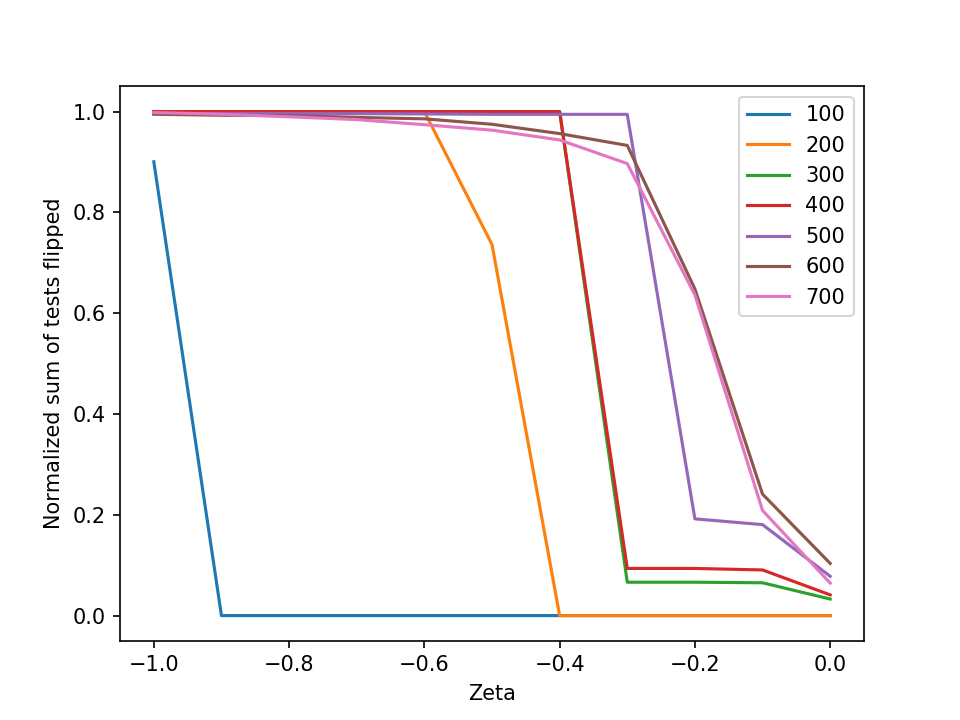

Text(0, 0.5, 'Normalized sum of tests flipped')

In [166]:
plt.figure()

for T in T_list:
    plt.plot(Ls, [sum(e_negs[3,T,L]) / len(e_negs[3,T,L]) for L in Ls], label=T)
    
plt.legend()
plt.xlabel('Zeta')
plt.ylabel('Normalized sum of tests flipped')

In [175]:
L_by_T = {
    100: -1,
    200: -0.5,
    300: -0.3,
    400: -0.3,
    500: -0.25,
    600: -0.2,
    700: -0.2
}

In [176]:
for i in range(num_trial):
    for T in T_list:
        X, y = Xs[i,T], ys[i,T]
        y_noisy = y_noisys[i,T]
        L = L_by_T[T]
        print(i, T, L)
        zs[i,T], e_negs[i,T] = decoder.solve_lp_z(X, y_noisy, L)
        

0 100 -1
0 200 -0.5
0 300 -0.3
0 400 -0.3
0 500 -0.25
0 600 -0.2
0 700 -0.2
1 100 -1
1 200 -0.5
1 300 -0.3
1 400 -0.3
1 500 -0.25
1 600 -0.2
1 700 -0.2
2 100 -1
2 200 -0.5
2 300 -0.3
2 400 -0.3
2 500 -0.25
2 600 -0.2
2 700 -0.2
3 100 -1
3 200 -0.5
3 300 -0.3
3 400 -0.3
3 500 -0.25
3 600 -0.2
3 700 -0.2
4 100 -1
4 200 -0.5
4 300 -0.3
4 400 -0.3
4 500 -0.25
4 600 -0.2
4 700 -0.2
5 100 -1
5 200 -0.5
5 300 -0.3
5 400 -0.3
5 500 -0.25
5 600 -0.2
5 700 -0.2
6 100 -1
6 200 -0.5
6 300 -0.3
6 400 -0.3
6 500 -0.25
6 600 -0.2
6 700 -0.2
7 100 -1
7 200 -0.5
7 300 -0.3
7 400 -0.3
7 500 -0.25
7 600 -0.2
7 700 -0.2
8 100 -1
8 200 -0.5
8 300 -0.3
8 400 -0.3
8 500 -0.25
8 600 -0.2
8 700 -0.2
9 100 -1
9 200 -0.5
9 300 -0.3
9 400 -0.3
9 500 -0.25
9 600 -0.2
9 700 -0.2


In [192]:
pred_e_negs = {}
for i in range(num_trial):
    for T in T_list:
        for t in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
            pred_e_negs[i,T,t] = threshold(e_negs[i,T], t)

KeyError: (0, 100)

In [178]:
pred_e_negs

{(0,
  100,
  0.1): array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 (0,
  100,
  0.2): array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 (0,
  100,
  0.3): array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 (0,
  100,
  0.4): array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 (0,
  100,
  0.5): array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 (0,
  100,
  0.6): array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [186]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]


In [181]:
e_negs_FNs = {}
e_negs_FPs = {}
e_negs_HDs = {}
for i in range(num_trial):
    for T in T_list:
        y = ys[i,T]
        y_noisy = y_noisys[i,T]
        real_FN = abs(y_noisy[y_noisy == 0] - y[y_noisy == 0])
        for t in thresholds:
            pred = pred_e_negs[i,T,t]
            e_negs_FNs[i,T,t] = num_false_negatives(real_FN, pred)
            e_negs_FPs[i,T,t] = num_false_positives(real_FN, pred)
            e_negs_HDs[i,T,t] = hamming_distance(real_FN, pred)

In [188]:
avg_e_negs_FNs = {}
avg_e_negs_FPs = {}
avg_e_negs_HDs = {}

for t in thresholds:
    avg_e_negs_FNs[t] = [np.mean([e_negs_FNs[i,T,t] for i in range(num_trial)]) for T in T_list]
    avg_e_negs_FPs[t] = [np.mean([e_negs_FPs[i,T,t] for i in range(num_trial)]) for T in T_list]
    avg_e_negs_HDs[t] = [np.mean([e_negs_HDs[i,T,t] for i in range(num_trial)]) for T in T_list]

<IPython.core.display.Javascript object>


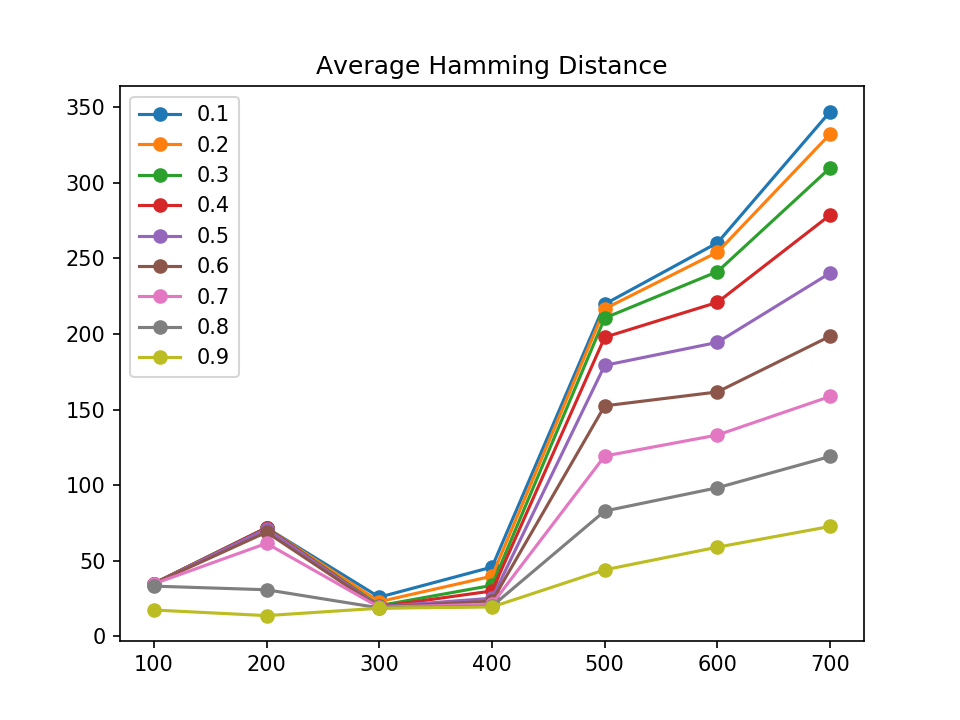

In [189]:
plt.figure()
for t in thresholds:
    plt.plot(T_list, avg_e_negs_HDs[t], '-o', label=t)
    plt.title('Average Hamming Distance')
plt.legend()

<IPython.core.display.Javascript object>


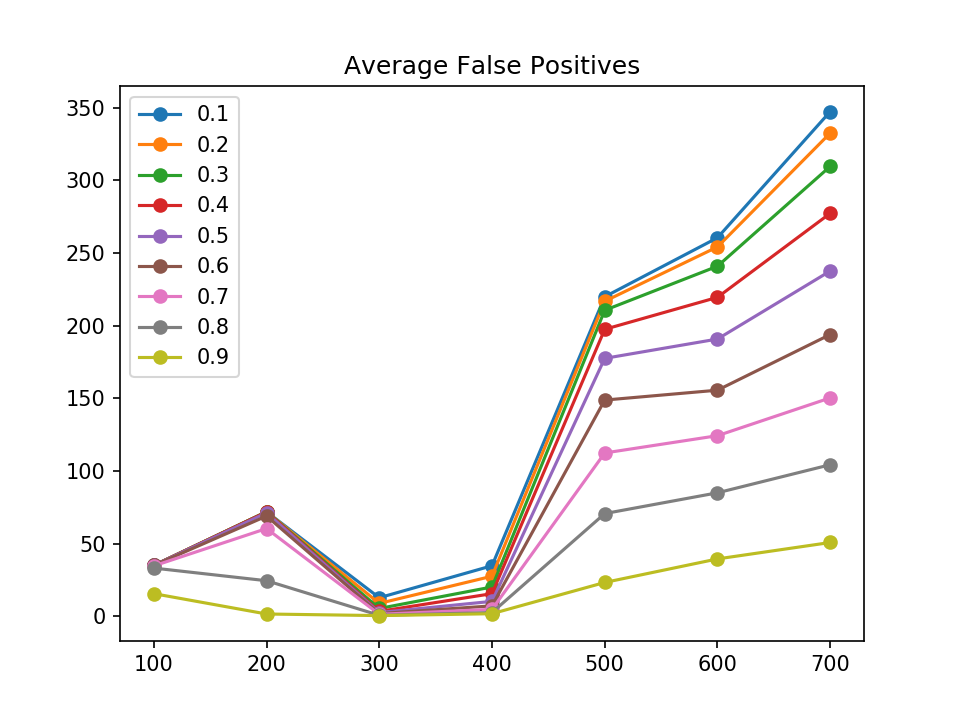

In [190]:
plt.figure()
for t in thresholds:
    plt.plot(T_list, avg_e_negs_FPs[t], '-o', label=t)
    plt.title('Average False Positives')
plt.legend()

<IPython.core.display.Javascript object>


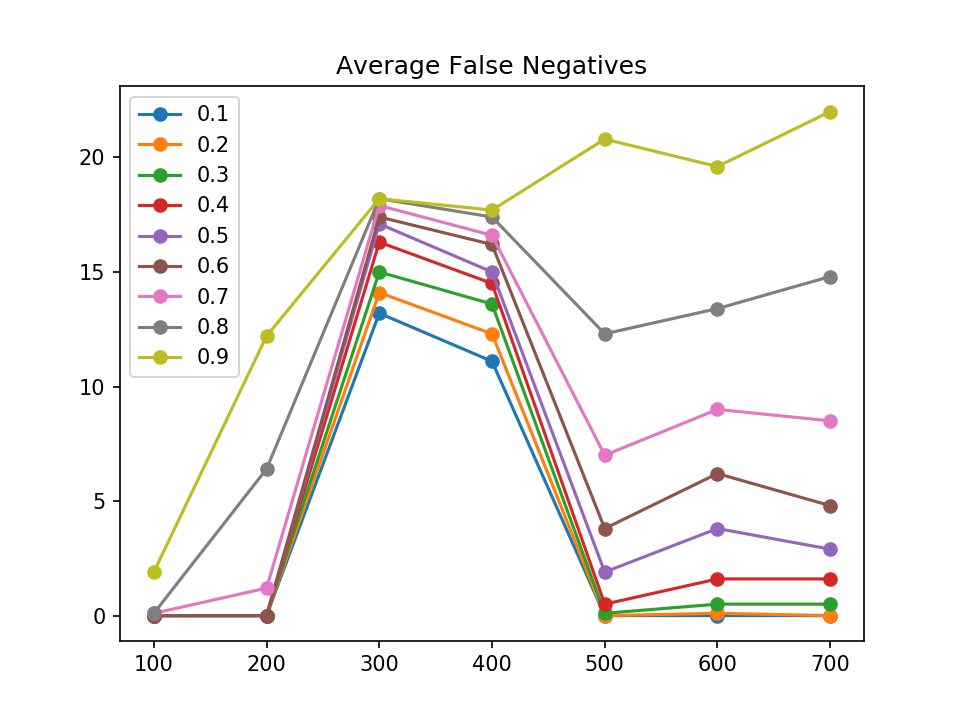

In [191]:
plt.figure()
for t in thresholds:
    plt.plot(T_list, avg_e_negs_FNs[t], '-o', label=t)
    plt.title('Average False Negatives')
plt.legend()

In [203]:
Xs[0,700].sum(axis=0)

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5.

In [204]:
Ks = {
    100: 1,
    200: 2,
    300: 3,
    400: 3,
    500: 4,
    600: 5,
    700: 5
}

In [205]:
q

0.1

In [207]:
zs_2 = {}
e_negs_2 = {}
for i in range(num_trial):
    for T in T_list:
        print(i, T)
        X, y = Xs[i,T], ys[i,T]
        y_noisy = y_noisys[i,T]
        K = Ks[T]
        lower_bound = q*T* (1 - (1-p)**(n*K/T))
        zs_2[i,T], e_negs_2[i,T] = decoder.solve_lp_z(X, y_noisy, 0, lower_bound=lower_bound)

0 100
0 200
0 300
0 400
0 500
0 600
0 700
1 100
1 200
1 300
1 400
1 500
1 600
1 700
2 100
2 200
2 300
2 400
2 500
2 600
2 700
3 100
3 200
3 300
3 400
3 500
3 600
3 700
4 100
4 200
4 300
4 400
4 500
4 600
4 700
5 100
5 200
5 300
5 400
5 500
5 600
5 700
6 100
6 200
6 300
6 400
6 500
6 600
6 700
7 100
7 200
7 300
7 400
7 500
7 600
7 700
8 100
8 200
8 300
8 400
8 500
8 600
8 700
9 100
9 200
9 300
9 400
9 500
9 600
9 700


In [208]:
pred_e_negs_2 = {}
for i in range(num_trial):
    for T in T_list:
        for t in thresholds:
            pred_e_negs_2[i,T,t] = threshold(e_negs_2[i,T], t)

In [209]:
e_negs_2_FNs = {}
e_negs_2_FPs = {}
e_negs_2_HDs = {}
for i in range(num_trial):
    for T in T_list:
        y = ys[i,T]
        y_noisy = y_noisys[i,T]
        real_FN = abs(y_noisy[y_noisy == 0] - y[y_noisy == 0])
        for t in thresholds:
            pred = pred_e_negs_2[i,T,t]
            e_negs_2_FNs[i,T,t] = num_false_negatives(real_FN, pred)
            e_negs_2_FPs[i,T,t] = num_false_positives(real_FN, pred)
            e_negs_2_HDs[i,T,t] = hamming_distance(real_FN, pred)

In [210]:
avg_e_negs_2_FNs = {}
avg_e_negs_2_FPs = {}
avg_e_negs_2_HDs = {}

for t in thresholds:
    avg_e_negs_2_FNs[t] = [np.mean([e_negs_2_FNs[i,T,t] for i in range(num_trial)]) for T in T_list]
    avg_e_negs_2_FPs[t] = [np.mean([e_negs_2_FPs[i,T,t] for i in range(num_trial)]) for T in T_list]
    avg_e_negs_2_HDs[t] = [np.mean([e_negs_2_HDs[i,T,t] for i in range(num_trial)]) for T in T_list]

<IPython.core.display.Javascript object>


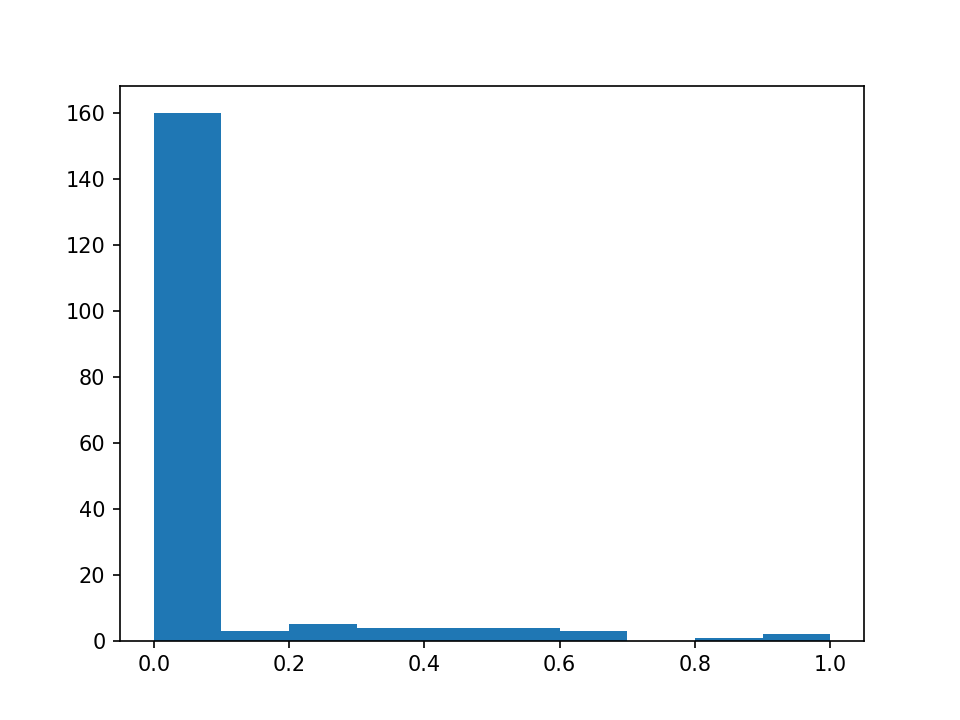

(array([160.,   3.,   5.,   4.,   4.,   4.,   3.,   0.,   1.,   2.]),
 array([4.08121498e-13, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

In [230]:
plt.figure()
plt.hist(e_negs[1,400])

<IPython.core.display.Javascript object>


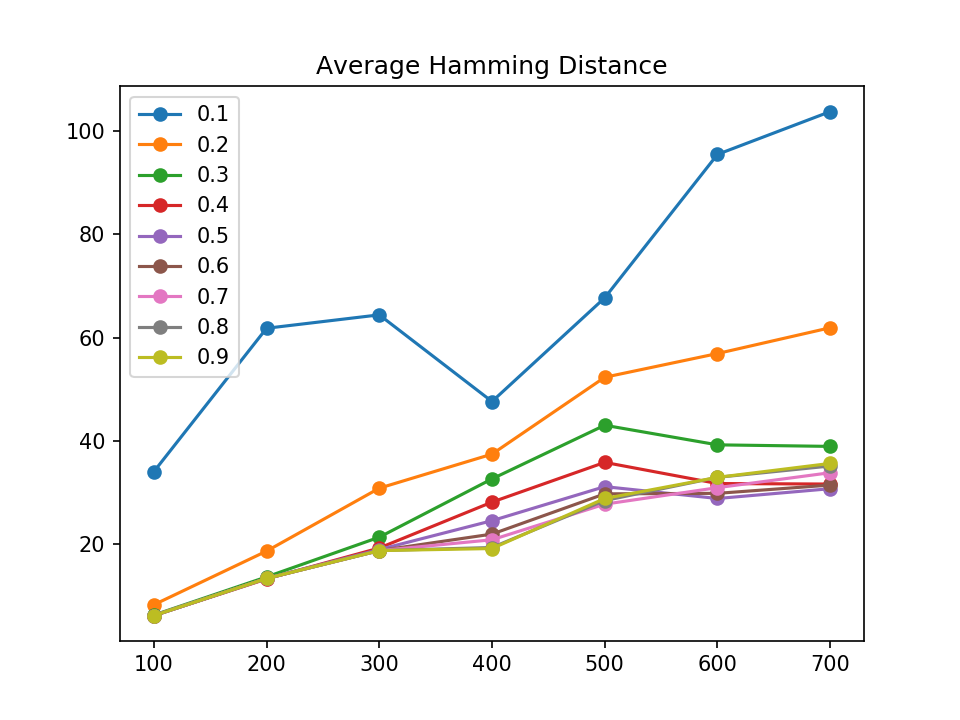

In [211]:
plt.figure()
for t in thresholds:
    plt.plot(T_list, avg_e_negs_2_HDs[t], '-o', label=t)
    plt.title('Average Hamming Distance')
plt.legend()

<IPython.core.display.Javascript object>


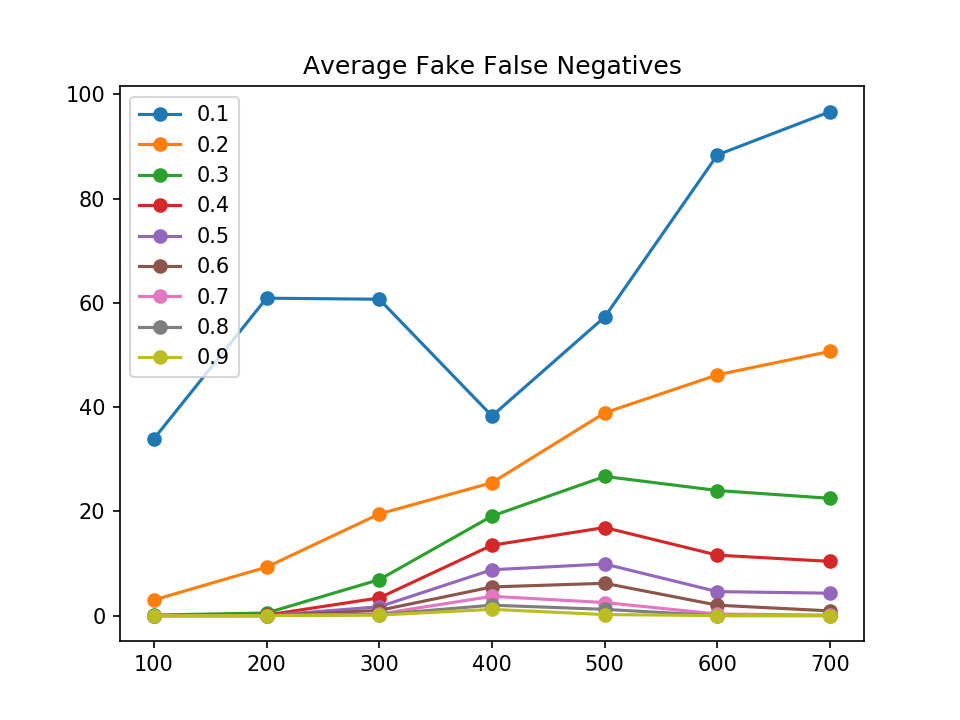

In [231]:
plt.figure()
for t in thresholds:
    plt.plot(T_list, avg_e_negs_2_FPs[t], '-o', label=t)
    plt.title('Average Fake False Negatives')
plt.legend()

<IPython.core.display.Javascript object>


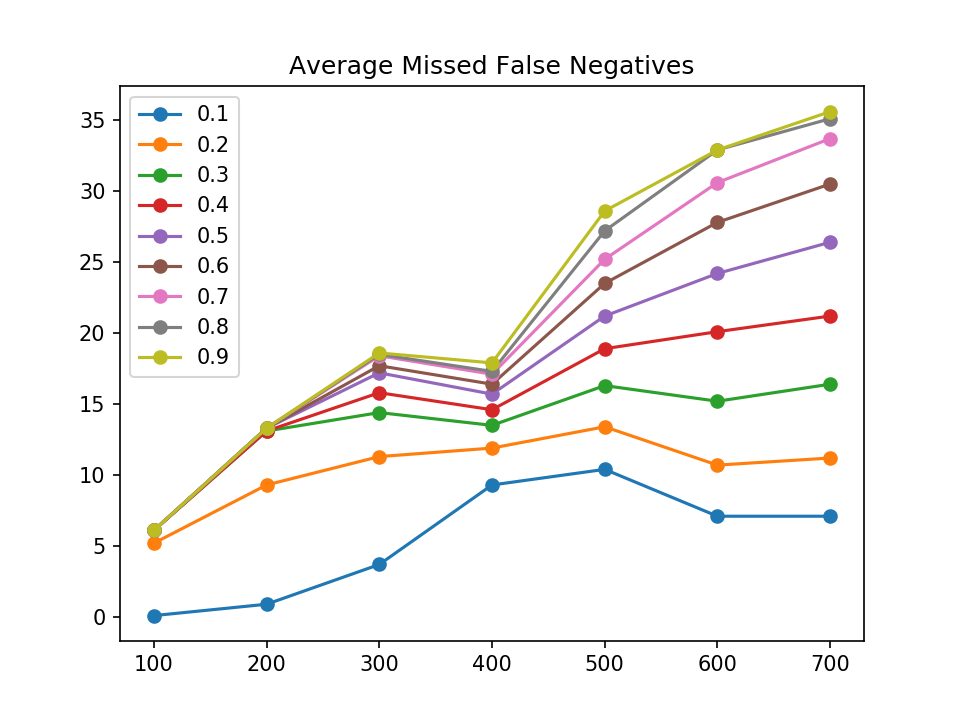

In [232]:
plt.figure()
for t in thresholds:
    plt.plot(T_list, avg_e_negs_2_FNs[t], '-o', label=t)
    plt.title('Average Missed False Negatives')
plt.legend()